In [51]:
import torch
import torch.nn as nn
import torchvision.transforms as t
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE

import os
import cv2
import h5py
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
def subtract_mean(x):
    mean_vector = [91.4953, 103.8827, 131.0912]
    x *= 255.
    x[0] -= mean_vector[0]
    x[1] -= mean_vector[1]
    x[2] -= mean_vector[2]
    return x

tf = t.Compose([
    t.Resize(256),
    t.CenterCrop(224),
    t.ToTensor(),
    t.Lambda(lambda x: subtract_mean(x))
])

def lower_resolution(img, res):
        w_i, h_i = img.size
        r = h_i/float(w_i)
        if res >= w_i or res >= h_i:
            return img
        if h_i < w_i:
            h_n = res
            w_n = h_n/float(r)
        else:
            w_n = res
            h_n = w_n*float(r)
        img2 = img.resize((int(w_n), int(h_n)), Image.BILINEAR)
        img2 = img2.resize((w_i, h_i), Image.BILINEAR)
        return img2

In [10]:
original = torch.load('senet50_ft_pytorch.pth');
for n, m in original.named_modules():
    if isinstance(m, nn.BatchNorm2d):
        m.momentum = 0.1
        m.eps = 1e-05

        
fine_tuned = torch.load('senet50_ft_pytorch.pth');
ckp = torch.load('models_ckp_11105.pth.tar', map_location='cpu')
print('Checkpoint after {} iterations with best acc1 of: {}'.format(ckp['epoch'], ckp['best_acc']))
for n, p in fine_tuned.named_parameters():
    p.data = ckp['model_state_dict'][n]
for n, m in fine_tuned.named_modules():
    if isinstance(m, nn.BatchNorm2d):
        m.momentum = 0.1
        m.eps = 1e-05
        

original.eval();       
original.cuda();

fine_tuned.eval();
fine_tuned.cuda();

Checkpoint after 11106 iterations with best acc1 of: 76.9141531323


In [40]:
res = [8, 16, 24, 32, 64, 128, 256]
names = ['domenico', 'vittorio', 'stefan']

with h5py.File('features.hdf5', 'a') as hf:
    

    for n in tqdm(names):
        for r in res:
            org_k = 'original_'+n+'_res_'+str(r)
            ft_k = 'finetuned_'+n+'_res_'+str(r)
            hf.create_dataset(org_k,  (0, 2048), maxshape=(None, None), dtype='f8')
            hf.create_dataset(ft_k,  (0, 2048), maxshape=(None, None), dtype='f8')
            
            with torch.no_grad():
                
                for img in os.listdir(os.path.join('../../face/', n)):
                    img_ = Image.fromarray(cv2.imread(os.path.join('../../face/', n, img)))
                    img_ = lower_resolution(img_, r)
                    img_ = tf(img_)
                    img_ = img_[np.newaxis, ::]
                    img_ = img_.cuda(non_blocking=True)
                    
                    descriptors_original_ = original(img_)
                    descriptors_finetuned_ = fine_tuned(img_)
                    
                    descriptors_original = descriptors_original_.detach().cpu().numpy()
                    descriptors_finetuned = descriptors_finetuned_.detach().cpu().numpy()
                    
                    hf[org_k].resize((hf[org_k].shape[0] + 1, hf[org_k].shape[1]))
                    hf[org_k][-descriptors_original.shape[0]:] = descriptors_original
                    
                    hf[ft_k].resize((hf[ft_k].shape[0] + 1, hf[ft_k].shape[1]))
                    hf[ft_k][-descriptors_finetuned.shape[0]:] = descriptors_finetuned

100%|██████████| 3/3 [02:14<00:00, 44.35s/it]


In [52]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [61]:
features_tsne = h5py.File('features_tsne.h5', 'w')

with h5py.File('./features.hdf5') as hf:
    for k in hf.keys():
        features_tsne.create_dataset(k, data=tsne.fit_transform(hf[k]))
        
features_tsne.close()

[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 21.149153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.184464
[t-SNE] KL divergence after 300 iterations: 0.530844
[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.514690
[t-SNE] KL divergence after 300 iterations: 0.781089
[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 7.473515
[t-SNE] KL divergence after 250 iterat

[u'finetuned_domenico_res_128', u'finetuned_domenico_res_16', u'finetuned_domenico_res_24', u'finetuned_domenico_res_256', u'finetuned_domenico_res_32', u'finetuned_domenico_res_64', u'finetuned_domenico_res_8', u'finetuned_stefan_res_128', u'finetuned_stefan_res_16', u'finetuned_stefan_res_24', u'finetuned_stefan_res_256', u'finetuned_stefan_res_32', u'finetuned_stefan_res_64', u'finetuned_stefan_res_8', u'finetuned_vittorio_res_128', u'finetuned_vittorio_res_16', u'finetuned_vittorio_res_24', u'finetuned_vittorio_res_256', u'finetuned_vittorio_res_32', u'finetuned_vittorio_res_64', u'finetuned_vittorio_res_8', u'original_domenico_res_128', u'original_domenico_res_16', u'original_domenico_res_24', u'original_domenico_res_256', u'original_domenico_res_32', u'original_domenico_res_64', u'original_domenico_res_8', u'original_stefan_res_128', u'original_stefan_res_16', u'original_stefan_res_24', u'original_stefan_res_256', u'original_stefan_res_32', u'original_stefan_res_64', u'original_s

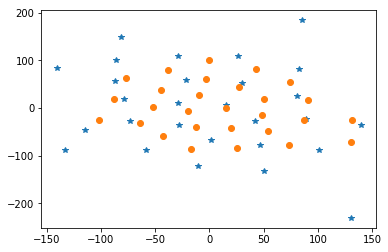

In [75]:
with h5py.File('./features_tsne.h5') as f:
    print(keys)
    plt.plot(f['finetuned_vittorio_res_24'][:, 0], f['finetuned_vittorio_res_24'][:, 1], linestyle='', marker='*')
    plt.plot(f['original_vittorio_res_24'][:, 0], f['original_vittorio_res_24'][:, 1], linestyle='', marker='o')